In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from IPython.display import display, HTML

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score

from scipy.optimize import brute
from skopt import forest_minimize, gbrt_minimize, dummy_minimize
from skopt import callbacks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall

In [ ]:
# Code to enable the use of the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# Ccode for print report and matrix side by side
CSS = """
.output {
    flex-direction: row;
}
"""

display(HTML('<style>{}</style>'.format(CSS)))

labels = [ "Normal", "Pneumonia", "Tuberculosis" ]

dataset = []
label = []

Size = 224

In [ ]:
#Read each image from the train and test data and assiging labels 

image_directory = r'C:\Users\rahulmaddula\Desktop\Sem 2\Data Driven Modeling\Assignments\Project\Final\Images'

Normal_images = os.listdir(image_directory + '/Normal/')
for i, image_name in enumerate(Normal_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpeg'):
        image = load_img(image_directory + '/Normal/' + image_name, color_mode = 'rgb')
        
        image = image.resize((Size,Size))
        dataset.append((img_to_array(image)))
        label.append(0)
        
Pneumonia_images = os.listdir(image_directory + '/Pneumonia/')
for i, image_name in enumerate(Pneumonia_images):    #Remember enumerate method adds a counter and returns the enumerate object
    
    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpeg'):
        image = load_img(image_directory + '/Pneumonia/' + image_name, color_mode ='rgb')
        
        image = image.resize((Size,Size))
        dataset.append((img_to_array(image)))
        label.append(1)
        
Tuberculosis_images = os.listdir(image_directory + '/Tuberculosis/')
for i, image_name in enumerate(Tuberculosis_images):    #Remember enumerate method adds a counter and returns the enumerate object

    if (image_name.split('.')[1] == 'png' or image_name.split('.')[1] == 'jpeg'):
        image = load_img(image_directory + '/Tuberculosis/' + image_name, color_mode ='rgb')
        
        image = image.resize((Size,Size))
        dataset.append((img_to_array(image)))
        label.append(2)
        

In [ ]:
#Processing the data to as input for the neural network
x_data = np.array(dataset)


#One hot encode y values for neural network. 
y_labels = to_categorical(label)

# Split the data for train and test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_labels, test_size = 0.1, random_state = 60616)

In [ ]:
#Setting the VGG16 model without the fully connected layers

base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (Size, Size, 3))
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#Setting the feature extraction model

model = Sequential()
model.add(base_model) 
model.add(Flatten())

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#Add fully connected layers for deep learning prediction

x = model.output  
x = Dense(4096, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
prediction_layer = Dense(3, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
VGG_model = Model(inputs=model.input, outputs=prediction_layer)


VGG_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = [Recall()])
print(VGG_model.summary()) 

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)             

In [ ]:
# Train the VGG16 Model

my_callbacks = [EarlyStopping(monitor = 'val_recall', mode = 'max', patience = 3)]


history = VGG_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks = my_callbacks, shuffle = False, batch_size=32)

Epoch 1/20
329/329 [==============================] - 161s 490ms/step - loss: 0.5812 - recall: 0.8169 - val_loss: 3659.6414 - val_recall: 0.6060
Epoch 2/20
329/329 [==============================] - 163s 495ms/step - loss: 0.3731 - recall: 0.8759 - val_loss: 227303.7812 - val_recall: 0.6376
Epoch 3/20
329/329 [==============================] - 166s 504ms/step - loss: 0.2878 - recall: 0.9038 - val_loss: 305255.0312 - val_recall: 0.9453
Epoch 4/20
329/329 [==============================] - 160s 488ms/step - loss: 0.2384 - recall: 0.9187 - val_loss: 533853.1875 - val_recall: 0.7974
Epoch 5/20
329/329 [==============================] - 159s 484ms/step - loss: 0.2035 - recall: 0.9299 - val_loss: 1736543.3750 - val_recall: 0.4094
Epoch 6/20
329/329 [==============================] - 157s 477ms/step - loss: 0.1736 - recall: 0.9396 - val_loss: 133931.1094 - val_recall: 0.8026


In [ ]:
#Predict the label for test data 
y_pred = VGG_model.predict(x_test)

# Converting the predicted values into a array of label
y_true_1 = np.array([np.argmax(y, axis=None, out=None) for y in y_test])
y_predict_1 = np.array([np.argmax(y, axis=None, out=None) for y in y_pred])

In [ ]:
# Assigning the labels integer with classes names
y_actual_1 = y_true_1.astype('object')
y_predicted_1 = y_predict_1.astype('object')


for i in range(len(labels)):
    y_actual_1[y_actual_1 == i] = labels[i]
    y_predicted_1[y_predicted_1 == i] = labels[i]


              precision    recall  f1-score   support

      Normal       0.99      0.41      0.58       377
   Pneumonia       0.93      1.00      0.96       430
Tuberculosis       0.65      0.99      0.78       363

    accuracy                           0.81      1170
   macro avg       0.86      0.80      0.78      1170
weighted avg       0.86      0.81      0.79      1170



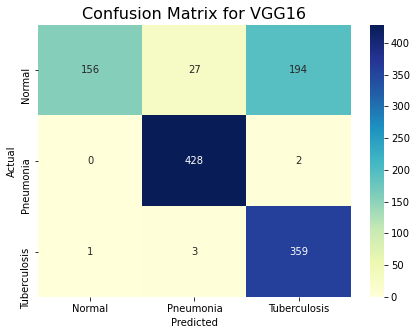

In [ ]:
# Print the classification report
print(classification_report(y_actual_1, y_predicted_1))

# Plot the Confusion Matrix 

y_actual_1 = pd.Series(y_actual_1, name='Actual')
y_predicted_1 = pd.Series(y_predicted_1, name='Predicted')
confusion_matrix = pd.crosstab(y_actual_1, y_predicted_1, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (7,5))
sns.heatmap(confusion_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix for VGG16", fontsize=16)
plt.show()

# VGG16 + RandomForest

In [ ]:
# Input for the Radom Forest model for training

x_train_feature =  model.predict(x_train)

# Input for the Radom Forest model for prediction

x_test_feature = model.predict(x_test)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 18.2732
Function value obtained: -0.9658
Current minimum: -0.9658
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.3180
Function value obtained: -0.9564
Current minimum: -0.9658
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7810
Function value obtained: -0.8504
Current minimum: -0.9658
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 7.4189
Function value obtained: -0.9547
Current minimum: -0.9658
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 36.7593
Function value obtained: -0.9658
Current minimum: -0.9658
Iteration No: 6 starte

C:\Users\jainp\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 22.5456
Function value obtained: -0.9675
Current minimum: -0.9684
Iteration No: 35 started. Searching for the next optimal point.
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 39.4847
Function value obtained: -0.9615
Current minimum: -0.9684
Iteration No: 36 started. Searching for the next optimal point.
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.8545
Function value obtained: -0.9137
Current minimum: -0.9684
Iteration No: 37 started. Searching for the next optimal point.
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 43.8707
Function value obtained: -0.9658
Current minimum: -0.9684
Iteration No: 38 started. Searching for the next optimal point.
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 40.8222
Function value obtained: -0.9581
Current minimum: -0.9684
Iteration No: 3

C:\Users\jainp\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 22.2513
Function value obtained: -0.9675
Current minimum: -0.9684
Iteration No: 42 started. Searching for the next optimal point.


C:\Users\jainp\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 22.3673
Function value obtained: -0.9675
Current minimum: -0.9684
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.7467
Function value obtained: -0.9145
Current minimum: -0.9684
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 40.0185
Function value obtained: -0.9641
Current minimum: -0.9684
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 22.5514
Function value obtained: -0.9675
Current minimum: -0.9684
Iteration No: 46 started. Searching for the next optimal point.


C:\Users\jainp\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 22.3952
Function value obtained: -0.9675
Current minimum: -0.9684
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 11.6712
Function value obtained: -0.9556
Current minimum: -0.9684
Iteration No: 48 started. Searching for the next optimal point.
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 21.6507
Function value obtained: -0.9607
Current minimum: -0.9684
Iteration No: 49 started. Searching for the next optimal point.
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 1.3844
Function value obtained: -0.8957
Current minimum: -0.9684
Iteration No: 50 started. Searching for the next optimal point.
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 1.1794
Function value obtained: -0.8342
Current minimum: -0.9684
Maximimum Recall

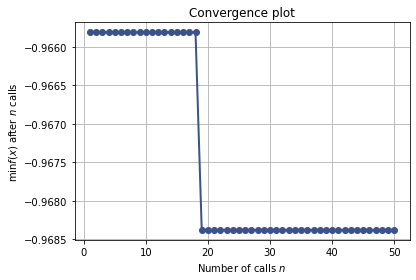

In [ ]:
# Hyperparameters tuning for Random Forest Parameters
# Bayesian Optimization

num_thread= 50
params = ['n_estimators', 'criterion', 'min_samples_split', 'min_samples_leaf', 'max_features','bootstrap']

#for model include item_Features
def objective(params):
    # unpack
    n_estimators, criterion, min_samples_split, min_samples_leaf, max_features, bootstrap = params
    
    model_iii = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, bootstrap = bootstrap, random_state=60616)
    model_iii.fit(x_train_feature, y_train)
    
    prediction_test = model_iii.predict(x_test_feature)
    recall = recall_score(y_test, prediction_test, average='micro')

    out = -recall
    # Handle some numerical issue going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

space = [(20, 40, 50, 60, 80, 100,),
         ('gini', 'entropy'),
         (5, 10, 15, 20, 25, 30, 35),
         (2, 6, 10, 14, 18, 22, 26, 30),
         ('auto', 'sqrt', 'log2'),
         (True, False),
        ]

try:
    res_fm = forest_minimize(objective, space, n_calls=num_thread,
                     random_state=60616,base_estimator= 'RF',acq_func='PI',
                     verbose=True, n_jobs= -1)
except ValueError:
    print('Forest diverged, random search intialized')
    res_fm = dummy_minimize(objective, space, n_calls=num_thread,
         random_state=60616,
         verbose=True)

print('Maximimum Recall_score found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')

for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))
from skopt.plots import plot_convergence
plot_convergence(res_fm);

In [ ]:
# Train the Random Forest Model
RF_model = RandomForestClassifier(n_estimators = 50, criterion = 'entropy', min_samples_split = 25, min_samples_leaf = 2, max_features= 'auto', bootstrap = False, random_state = 60616)

RF_model.fit(x_train_feature, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', min_samples_leaf=2,
                       min_samples_split=25, n_estimators=50,
                       random_state=60616)

In [ ]:
#Now predict using the trained RF model
y_pred_RF = RF_model.predict(x_test_feature)

# Converting the predicted values into a array of label
y_true = (np.array([np.argmax(y, axis=None, out=None) for y in y_test]))
y_predict = (np.array([np.argmax(y, axis=None, out=None) for y in y_pred_RF]))

In [ ]:
# Assigning the labels integer with classes names

y_actual = y_true.astype('object')
y_predicted = y_predict.astype('object')

for i in range(len(labels)):
    y_actual[y_actual == i] = labels[i]
    y_predicted[y_predicted == i] = labels[i]

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97       377
   Pneumonia       0.98      0.99      0.98       430
Tuberculosis       0.98      0.98      0.98       363

    accuracy                           0.98      1170
   macro avg       0.98      0.98      0.98      1170
weighted avg       0.98      0.98      0.98      1170



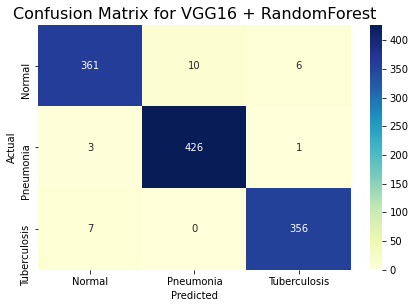

In [ ]:
print(classification_report(y_actual, y_predicted))

# Plot the Confusion Matrix
y_actual = pd.Series(y_actual, name='Actual')
y_predicted = pd.Series(y_predicted, name='Predicted')
confusion_matrix = pd.crosstab(y_actual, y_predicted, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize = (7,4.5))
sns.heatmap(confusion_matrix, annot=True,fmt='d',cmap="YlGnBu").set_title(
    "Confusion Matrix for VGG16 + RandomForest", fontsize=16)
plt.show()